# Algoritmo di ricerca output massimo - Keithley

Il programma cerca entro un numero massimo di tentativi (max_tries) la configurazione del sistema che massimizza un singolo output (connesso al Keithley), al termine ne salva la configurazione su file. 

## 1) Import

In [1]:
# Required imports
import sys
username = 'admin' # 'admin' for BO1 lab
sys.path.append('c:/users/'+ username +'/miniconda3/lib/site-packages')
path_to_MyCustomPackage = '../' # relative path to the MyCustomPackage folder 
sys.path.append(path_to_MyCustomPackage)
from MyCustomPackage import mycustommodule
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, widgets
from matplotlib.patches import Polygon
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython.display import display
from IPython.display import clear_output
import qontrol
import os
import time
import numpy as np
import datetime
import os.path
import math
import logging
import wx
# KEITHLEY ADDITION -----
import pyvisa
# -----------------------

%matplotlib widget

app = wx.App(False) # If you get the error The wx.App object must be created first!, uncomment this line


## 2) Dichiarazione variabili e setup driver

In [2]:
# Variable declarations
max_tries = 1
voltage = 12.0

"""
1-1 e 1-2 : channels = [10,20,25]
1-3 e 1-4 : channels = [10,20,26]
2-1 e 2-2 : channels = [6,12,9,10,20,25]
2-3 e 2-4 : channels = [6,12,9,10,17,19,20,22,26] 
2-5 e 2-6 : channels = [6,9,19,27]
3-1 e 3-2 : channels = [6,12,9,10,20,25]
3-3 e 3-4 : channels = [6,12,9,10,17,19,20,22,26]
3-5 e 3-6 : channels = [6,9,19,27]
4-1 e 4-2 : channels = [4,9,20,25]
4-3 e 4-4 : channels = [4,11,8,9,17,19,20,22,26]
4-5 e 4-6 : channels = [4,11,8,9,17,16,15,19,27]
5-1 e 5-2 : channels = [4,9,20,25]
5-3 e 5-4 : channels = [4,11,8,9,17,19,20,22,26]
5-5 e 5-6 : channels = [4,11,8,9,17,16,15,19,27]
6-3 e 6-4 : channels = [1,8,19,26]
6-5 e 6-6 : channels = [1,8,16,15,19,27]
"""

channels = [4,9,20,25]
channels.reverse()
#np.random.shuffle(channels)

np.random.shuffle(channels)
channel_PD = 3 # the channel connected to the photodiode
voltage_PD = 0 # the voltage to be set to the photodiode
voltage_start = [0.0 for j in range(len(channels))] # starting voltage values for each channel
voltage_stop = [voltage for j in range(len(channels))] # stopping voltage values for each channel
voltage_step = [0.5 for j in range(len(channels))] # voltage steps for each channel
max_current = 8 # current compliance
max_voltage = 12.0 # voltage compliance
measured_voltage = [[[] for i in range(len(channels))] for j in range(len(channels))] # measured_voltage[channels][channel_under_sweep][measurement]
measured_current = [[[] for i in range(len(channels))] for j in range(len(channels))] # current measurements
PD_voltage = [[] for i in range(len(channels))] # PD voltage measurements
PD_current = [[] for i in range(len(channels))] # PD current measurements
F_move_on = 0 # FLAG : 0 for pausing when a channel sweep is done
F_overlapping_plots = 1 # FLAG : 0 for non overlapping plots, not 0 otherwise 
F_triangular = 1 # FLAG : 0 for ramp sweep, 1 for triangular sweep
now = datetime.datetime.now() # retrieve current date and time (for file name)


# Configuration (Laser and Amplifier)
laser_wavelength = 850
laser_power = 4.93
amplifier_gain = 20
device_model = "Q3_-04_+06"
device = device_model + "_" + str(voltage)  + "V_2sweep"


#Create a custom directory
today = str(datetime. date. today()) 
curr_year = today[:4]; curr_month = today[5:7] 
curr_day = today[8:10]
today = datetime.datetime.now()

if today.hour < 10:
    hour = "0" + str(today.hour)
else:
    hour = today.hour
if today.minute < 10:
    minute = "0" + str(today.minute)
else:
    minute = today.minute   
    
# Directory
directory = curr_year + curr_month + curr_day + str(hour) + str(minute)
  
# Parent Directory path
save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/" + device_model + "/"
  
# Path
path = os.path.join(save_path, directory)
save_path = path

# Create the directory
os.makedirs(path)
print("Directory '% s' created" % directory)


# Set the right path and file

file_name = "Algoritmo_di_ricerca_output_massimo_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '.txt' 
completeName = os.path.join(save_path, file_name)

# Create an ID an initialize it to a number of zeros equal to the maximum length of the total steps
ID = "1"

if F_triangular == 1:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*max_tries*2)
else:
    total_steps = int(((voltage_stop[0]-voltage_start[0])/voltage_step[0])*len(channels)*max_tries)

for i in range(len(str(total_steps))):
    ID = ID + "0"
    
# ------------------ BUILD THE NEW TABLE FOR SAVING CONFIGURATION ---------------------------------

# System configuration will be a list (A) of lists (B). Each element of the list (A) identifies
# an istantaneous configuration of the system (stored in a list (B)), composed as:
#        [ID, F_triangular, valore_output_keithley, channels[channel_n], I1, V1, ... , In, Vn]

system_configuration = [[] for _ in range(total_steps)]
    

# Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
timestamp = now.strftime("%d/%m/%Y %H:%M:%S")
configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
              + str(amplifier_gain) + '[dB]'
annotation = '\n%TEST ALGORITMO DI RICERCA OUTPUT MASSIMO CON KEITHLEY, DETECTOR INTEGRATI. INPUT 4 E DETECTOR DI OUTPUT 1.\n'

voltage_parameters = '%' # voltage_parameters are voltage_start, voltage_stop, voltage_step, triangular
for element in voltage_start:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_stop:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%'
for element in voltage_step:
    voltage_parameters += str(element) + '\t'
voltage_parameters += '\n%' + str(F_triangular) + '\n'

description = '%Swipe sulla tensione con onda sinusoidale su un canale, canali rimanenti a 0 V.Ciascun canale pilota una termoresistenza.' + device
header = '%'+timestamp+configuration+annotation+voltage_parameters+description

# Setup Qontroller
serial_port_name = "COM3" #"COM3" #"/dev/tty.usbserial-FT06QAZ5" # name of the USB Serial Port #//./COM11
q = qontrol.QXOutput(serial_port_name = serial_port_name, response_timeout = 0.1)

# Set the compliances
for channel in range(q.n_chs):
    q.imax[channel] = max_current
    q.vmax[channel] = max_voltage

# Video Debugging
print ("Qontroller '{:}' initialised with firmware {:} and {:} channels".format(q.device_id, q.firmware, q.n_chs) )

# KEITHLEY ADDITION ----------
rm = pyvisa.ResourceManager()
rm.list_resources()


event_type=pyvisa.constants.EventType.service_request
event_mech=pyvisa.constants.EventMechanism.queue
# FROM THE INSTRUMENT WEB-INTERFACE THE NAME IS 
# TCPIP::169.254.207.124::inst0::INSTR
keithley_address_string = 'TCPIP::169.254.50.53::inst0::INSTR' # < ------------- CHECK IT!
inst = rm.open_resource(keithley_address_string)

# Dispolaying Keithley device information
print('Resource name  :', inst.resource_name)
print('Resource info  :',inst.resource_info)
print('Resource class :',inst.resource_class)
print('Resource manuf.:',inst.resource_manufacturer_name)
inst.write('*RST')                   #Reset
inst.write('TRAC:CLE')               # clear the dafault buffer "defbuffer1"
print(inst.query('*IDN?'))
# ---------------------------

Directory '202205131519' created
Qontroller 'Q8b-0471' initialised with firmware v2.4.1 and 32 channels
Resource name  : TCPIP0::169.254.50.53::inst0::INSTR
Resource info  : ResourceInfo(interface_type=<InterfaceType.tcpip: 6>, interface_board_number=0, resource_class='INSTR', resource_name='TCPIP0::169.254.50.53::inst0::INSTR', alias=None)
Resource class : INSTR
Resource manuf.: National Instruments
KEITHLEY INSTRUMENTS,MODEL 2450,04451367,1.6.7c



## 3) Definizione funzioni

In [3]:
def keithley_voltage_sweep(inst, V_start, V_stop, points, current_compliance = '3e-02', ms_delay = 0.01): #3e-02 30mA of current compliance by default
    # Make a voltage sweep and measure current both with autorange. Voltage goes from V_start to V_stop with points number of points and 
    # starting after ms_delay ms
    inst.write('*RST')                   #Reset
    inst.write('TRAC:CLE')               # clear the dafault buffer "defbuffer1"
    inst.write('SENS:FUNC "CURR"')       # Set current measurements
    inst.write('SENS:CURR:RANG:AUTO ON') # Set current range
    inst.write('SENS:CURR:RSEN OFF')     # Set 2wires (4wires off)
    inst.write('SOUR:FUNC VOLT')         # Set voltage source
    inst.write('SOUR:VOLT:RANG:AUTO ON') # Set voltage range:auto
    inst.write('SOUR:VOLT:ILIM '+ current_compliance)       # Set current compliance
    inst.write('SOUR:SWE:VOLT:LIN '+ str(V_start) +', '+ str(V_stop) +', '+ str(points) +', '+ str(ms_delay)) #('SOUR:SWE:VOLT:LIN -2.5, 2.5, 51, 0.01')
    inst.write('OUTPut ON')              # turns the output on
    inst.write(':INIT')                  # Start!
    #inst.write('*WAI')                   # wait until all commands are complete
    time.sleep(35)
    x=np.array(inst.query_ascii_values('TRAC:DATA? 1, '+ str(points) +', "defbuffer1", SOUR')) # retrieve the voltage readings
    y=np.array(inst.query_ascii_values('TRAC:DATA? 1, '+ str(points) +', "defbuffer1", READ')) # retrieve the current readings
    inst.write('TRAC:CLE') # clear the dafault buffer "defbuffer1"
    return [x,y]


def keithley_single_measure_complete_procedure(inst, sense = 'CURR', source = 'VOLT', sourcevalue = 1e-2, compliance = 1e-2): # by default it measures current. To measure voltage, insert 'VOLT'
    inst.write('*RST') # Reset
    inst.write('TRAC:CLE') # clear the dafault buffer "defbuffer1"
    inst.write('SENS:'+ sense +':RANG:AUTO ON') # enable autorange
    inst.write('SOUR:FUNC '+ str(source))         # Set source
    inst.write('SOUR:' + str(source) + ' ' + str(sourcevalue))
    if source == 'VOLT': # Set proper compliance
        inst.write('SOUR:VOLT:ILIM ' + str(compliance))
    else:
        inst.write('SOUR:CURR:VLIM ' + str(compliance))
    inst.write('OUTPut ON')              # turns the output on
    measurement = inst.query_ascii_values('MEAS:'+ sense +'? ' )#'READ') # Retrieve one measurement of the specified type
    inst.write('OUTPut OFF')              # turns the output on
    inst.write('TRAC:CLE') # Clear default buffer defbuffer1
    return measurement


def keithley_single_measure(inst, sense = 'CURR', source = 'VOLT', sourcevalue = 1e-2, compliance = 1e-2): # by default it measures current. To measure voltage, insert 'VOLT'
    inst.write('TRAC:CLE') # clear the dafault buffer "defbuffer1"
    inst.write('SENS:'+ sense +':RANG:AUTO ON') # enable autorange
    inst.write('SOUR:FUNC '+ str(source))         # Set source
    inst.write('SOUR:' + str(source) + ' ' + str(sourcevalue))
    if source == 'VOLT': # Set proper compliance
        inst.write('SOUR:VOLT:ILIM ' + str(compliance))
    else:
        inst.write('SOUR:CURR:VLIM ' + str(compliance))
    measurement = inst.query_ascii_values('MEAS:'+ sense +'? ' )#'READ') # Retrieve one measurement of the specified type
    #inst.write('TRAC:CLE') # Clear default buffer defbuffer1
    return measurement


def save_whole_system_configuration(system_configuration, save_path = save_path): # save all the configurations for each step of the algorithm  
    file_name = "Algoritmo_di_ricerca_output_massimo_keithley_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '_CONFIGURAZIONE_COMPLETA.txt' 
    completeName = os.path.join(save_path, file_name)
    
    # Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
    global timestamp,annotation
    configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
                  + str(amplifier_gain) + '[dB]'
    #annotation = '\n%TEST ALGORITMO DI RICERCA OUTPUT MASSIMO CON KEITHLEY, DETECTOR INTEGRATI. INPUT 1 E OUTPUT 1.\n'

    voltage_parameters = '%' # voltage_parameters are voltage_start, voltage_stop, voltage_step, triangular
    for element in voltage_start:
        voltage_parameters += str(element) + '\t'
    voltage_parameters += '\n%'
    for element in voltage_stop:
        voltage_parameters += str(element) + '\t'
    voltage_parameters += '\n%'
    for element in voltage_step:
        voltage_parameters += str(element) + '\t'
    voltage_parameters += '\n%' + str(F_triangular) + '\n'

    description = '%Swipe sulla tensione con onda sinusoidale su un canale, canali rimanenti a 0 V.Ciascun canale pilota una termoresistenza.' + device
    header = '%'+ timestamp+configuration+annotation+voltage_parameters+description
    
    # Write the header and the column headers to the file
    meas_file = open(completeName, "a")
    meas_file.write(header)
    meas_file.write("\n%ID\tF_triangular\tKeithley Output\tActive channel")
    for j in range(len(channels)):
        meas_file.write("\tCh" + str(channels[j]) + "[mA]\tCh" + str(channels[j]) + "[V]")
    meas_file.write("\n")
    
    # Write each element of the target configuration list, going newline 
    for k in system_configuration:
        for z in range(len(k)-1):
            meas_file.write(str(k[z]) + '\t')
        meas_file.write(str(k[-1]) + '\n')
    
def save_optimal_configuration(target_configuration, save_path = save_path): # save only the configurations referring to the optimized maxima
    # Set the right path and file
    #save_path = "G:/Shared drives/FMPS Archive/Projects/0_QPIXPAD/QPX4/Opt.Meas/"+ device_model +"/"
    file_name = "Algoritmo_di_ricerca_output_massimo_keithley_" + now.strftime("%d_%m_%Y_%H_%M_%S")+ device + '.txt' 
    completeName = os.path.join(save_path, file_name)

    # Build the header of the file as timestamp+configuration+annotation+voltage_parameters+description
    global timestamp,annotation
    configuration = '\n%Laser Wavelength:' + str(laser_wavelength) + '[nm]\n%Laser Power:' +str(laser_power) + '[mW]\n%Amplifier Gain:' \
              + str(amplifier_gain) + '[dB]'

    #annotation = '\n%TEST ALGORITMO DI RICERCA OUTPUT MASSIMO CON KEITHLEY, DETECTOR INTEGRATI. INPUT 1 E OUTPUT 1.\n'
    termistori = "%" + str(channels) + "\n" #1,4,6,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,25,26,27\n'
    header = '%'+ timestamp+configuration+annotation+termistori+'\n'

    # Write the header and the column headers to the file
    config_file = open(completeName, "a")
    config_file.write(header)
    config_file.write("%ID\tKeithley Output")
    for j in range(len(channels)):
        config_file.write("\tCh" + str(channels[j]) + "[V]")
    config_file.write("\n")
    config_file.close()
    config_file = open(completeName, "a") 
            
    # Write each element of the target configuration list, going newline 
    for k in target_configuration:
        for z in range(len(k)):
            if z < 2:
                config_file.write(str(k[z]) + '\t')
            else:
                for w in range(len(k[z])-1):
                    config_file.write(str(k[z][w]) + '\t')
        config_file.write(str(k[-1][-1]) + '\n')
    
    config_file.close()

## 4) Ricerca del massimo


PERFORMING TRY N.1 NOW 


DRIVING CHANNEL 20 NOW 


Voltage maximum for channel 20 found: 8.0 V

Corresponding output from Keithley: -8.760567e-06 A

DRIVING CHANNEL 25 NOW 


Voltage maximum for channel 25 found: 11.4999 V

Corresponding output from Keithley: -2.565784e-05 A

DRIVING CHANNEL 4 NOW 


Voltage maximum for channel 4 found: 11.4999 V

Corresponding output from Keithley: -2.565784e-05 A

DRIVING CHANNEL 9 NOW 


Voltage maximum for channel 9 found: 11.4999 V

Corresponding output from Keithley: -2.565784e-05 A

System configuration is: 

[[1000, 1, -7.461698e-06, 20, -0.0813, 0.0, -0.0406, 0.0, -0.0813, 0.0, -0.122, 0.0], [1001, 1, -7.465873e-06, 20, 0.2848, 0.4998, -0.0813, 0.0, -0.122, 0.0, -0.0813, 0.0], [1002, 1, -7.498001e-06, 20, 0.5696, 0.9999, -0.0813, 0.0, -0.0813, 0.0, -0.122, 0.0], [1003, 1, -7.48566e-06, 20, 0.8951, 1.4998, -0.0406, 0.0, -0.122, 0.0, -0.122, 0.0], [1004, 1, -7.616585e-06, 20, 1.2613, 1.9999, -0.0406, 0.0, -0.0813, 0.0, -0.122, 0.0], [1005, 1, 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
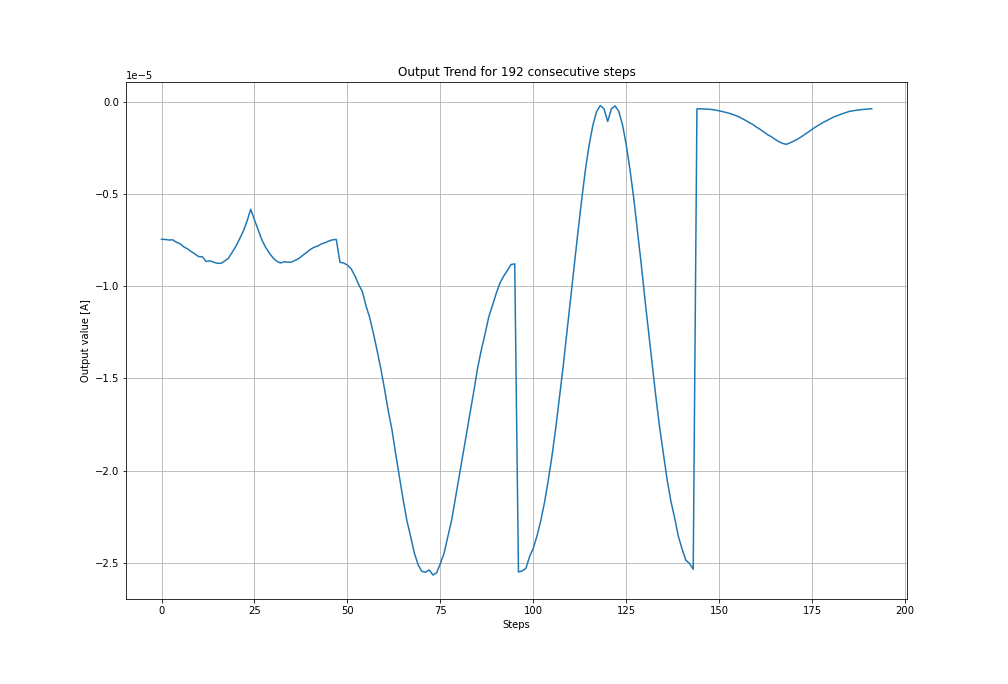

Qontroller.issue_command: Warning: Failed to write with command 'I7=0'. Timed out


In [ ]:
"""
# Starting Pico with range of 2V, sample interval of 250 microseconds and 5000 total samples
ps = mycustommodule.ps
ctypes = mycustommodule.ctypes
channel_range = ps.PS4000_RANGE['PS4000_5V']
sampleInterval = ctypes.c_int32(250) # in sample units specified by sampleUnits
sampleUnits = ps.PS4000_TIME_UNITS['PS4000_US']
sizeOfOneBuffer = 10 # size of a single buffer
numBuffersToCapture = 1 # totalSamples = sizeOfOneBuffer * numBuffersToCapture
mycustommodule.pico_start(channel_range, sampleInterval = sampleInterval, sampleUnits = sampleUnits, sizeOfOneBuffer = sizeOfOneBuffer, numBuffersToCapture = numBuffersToCapture)
"""
target_configuration = [[0, 0.0, [0.0 for j in range(len(channels))]] for i in range(len(channels))] # list of sublist of two elements. First element is output voltage, second element is a list of all driving voltages for each channel
voltage_max = 0.0
max_attuale = 0.0 # POLARIZZANDO IN INVERSA, IL MASSIMO IN REALTA' QUI E'UN MINIMO

current_step = 0


# set all channels to their voltage_start values
for k in range(len(channels)):
    q.v[channels[k]] = float(voltage_start[k])

# Turns the Keithley output on
inst.write('OUTPut ON')  
    
for i in range(max_tries): # ricerca fino a max_tries e proponi il miglior risultato
    print("\nPERFORMING TRY N.{:} NOW \n" .format(i+1))
    
    #sweep di tensione su ogni canale
    for channel_n in range(len(channels)): # esamina tutti i dof (canali/termoresistenze)
        x = channel_n
        print("\nDRIVING CHANNEL {:} NOW \n" .format(channels[channel_n]))

        #check if we want to generate a triangular sweep or not
        if F_triangular == 1:
            sweep_range = np.concatenate((np.arange(voltage_start[channel_n], voltage_stop[channel_n], voltage_step[channel_n]),\
                            np.arange(voltage_stop[channel_n], voltage_start[channel_n], -voltage_step[channel_n])))
        elif F_triangular == 0:
            sweep_range = np.arange(voltage_start[0], voltage_stop[0]+voltage_step[0], voltage_step[0])
        else:
            print('invalid value for triangular')
            
        for voltage_sweep in sweep_range: 
            q.v[channels[channel_n]] = float(voltage_sweep)
            temp_voltage = q.v[channels[channel_n]]

            #mycustommodule.pico_acquire_measurement(channel_range, sampleInterval = sampleInterval, sampleUnits = sampleUnits, sizeOfOneBuffer = sizeOfOneBuffer, numBuffersToCapture = numBuffersToCapture);
            
            valore_output_keithley = keithley_single_measure(inst, sense = 'CURR', source = 'VOLT', sourcevalue = -3)[0]
            #if valore_output_keithley > max_attuale: # se trovi un nuovo massimo, salvalo al posto del massimo finora trovato
            if valore_output_keithley < max_attuale: # POLARIZZANDO IN INVERSA, QUI IL MASSIMO IN REALTA' E' UN MINIMO
                voltage_max = q.v[channels[channel_n]]
                max_attuale = valore_output_keithley
                
            # ----- UPDATING THE CONFIGURATION SYSTEM LIST ----------------------
            
            # Creating a fixed length list for first row (for higher performance)
            new_row = [-1 for _ in range((len(channels)*2)+4)]

            # Populate first part of the new row with: ID, flag for triangular sweep, voltage value from pico, active channel
            new_row[0] = int(ID)
            new_row[1] = F_triangular
            new_row[2] = valore_output_keithley
            new_row[3] = channels[channel_n]

            # Populate remaining part of the new row with: I1, V1, ..., In, Vn
            for j in range(len(channels)): # acquire voltage and current for all channels. Then print them on screen and save them on file
                temp_voltage = q.v[channels[j]]
                temp_current = q.i[channels[j]]
                new_row[2*j+4] = temp_current
                new_row[2*j+5] = temp_voltage
                
            system_configuration[current_step] = new_row
            current_step += 1
            
            # ---------------------------------------------------------------------
            
            # Take a screenshot of a resolution of screen_resolution and cutting everything that is on the left of xsrc (in pixels) and above ysrc
            mycustommodule.take_screenshot(xdest= 0, ydest = 0, xsrc = 960, ysrc = 0, image_name = str(ID), save_path = save_path, screen_resolution = [960,1080])
            ID = int(ID) + 1
            
        q.v[channels[channel_n]] = voltage_max # setta il canale attuale alla tensione corrispondente al suo massimo
        print("\nVoltage maximum for channel {:} found: {:} V" .format(channels[channel_n],voltage_max))
        
        target_configuration[channel_n][0] = int(ID)
        
        target_configuration[channel_n][1] = max_attuale # salva l'output del massimo per il canale attuale
        print("\nCorresponding output from Keithley: {:} A" .format(max_attuale))
        
        # Take a screenshot of a resolution of screen_resolution and cutting everything that is on the left of xsrc (in pixels) and above ysrc
        #mycustommodule.take_screenshot(xdest= 0, ydest = 0, xsrc = 960, ysrc = 0, image_name = str(ID), save_path = save_path, screen_resolution = [960,1080])
        
        # storing in target_configuration the entire current configuration (corresponding to the current found maximum)
        for k in range(len(channels)):
            target_configuration[channel_n][2][k] = q.v[channels[k]] # salva per il canale attuale, nella lista delle driving voltages, ciascun driving voltage
        
# Turns the Keithley output off
inst.write('OUTPut OFF')

#print(target_configuration)
print("\nSystem configuration is: \n")
print(system_configuration)

# Set the System to last row of target configuration (i.e. the configuration resembling the maximum for the last sweep performed)
print("\nSetting the system to last row of target configuration\n")
for k in range(len(target_configuration[-1][2])):
    q.v[channels[k]] = target_configuration[-1][2][k]

save_whole_system_configuration(system_configuration)
save_optimal_configuration(target_configuration)

print("\nALL DONE")

#Plotting the trend of the output ----------------------------

data_figure = plt.figure("Output optimization")
data_figure.set_size_inches(14, 9.5, forward=True)
data_plot = data_figure.add_subplot(111)

y_values = []
for i in range(len(system_configuration)):
    y_values.append(system_configuration[i][2])
data_plot.plot(y_values)
#data_plot.legend()
    
data_plot.set_xlabel('Steps')
data_plot.set_ylabel('Output value [A]')
data_plot.set_title('Output Trend for ' + str(len(system_configuration)) + ' consecutive steps')
data_plot.grid(True)
plt.savefig(save_path + "/" + "Output_optimization_plot.png")
plt.show()
# -----------------------------------------------------------


# Set all channels to zero
q.v[:] = 0
q.i[:] = 0

# Close the communication with the driver
q.close()

print("\nALL DONE")